In [238]:
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline 
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np 
import xgboost as xgb
from matplotlib.offsetbox import AnchoredText
import heapq
import math 
from nasspython.nass_api import nass_data
from NdviApi import NDVI
import seaborn as sns

In [239]:
plt.style.use('ggplot')

In [240]:
""" 
Helpful Links:
https://geo.fas.usda.gov/GADAS/index.html#
https://glam1.gsfc.nasa.gov/
https://www.mdpi.com/2072-4292/13/21/4227
https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
"""

' \nHelpful Links:\nhttps://geo.fas.usda.gov/GADAS/index.html#\nhttps://glam1.gsfc.nasa.gov/\nhttps://www.mdpi.com/2072-4292/13/21/4227\nhttps://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db\n'

In [241]:

# Generic function to initialize dataframes from USDA Quickstats data
def initialize_df(states, week, start_yr, end_yr, freq, suffix, var):
    temp = pd.DataFrame(nass_data("B3744D45-DFBE-3B88-AFB1-25CBC8E64550", agg_level_desc="STATE", freq_desc=freq, short_desc=var)['data'])
    temp = temp[temp["state_name"].isin(states)]
    if (freq == "WEEKLY"):
        temp = temp[temp["reference_period_desc"].eq(f"WEEK #{week}")]
    elif (freq == "ANNUAL"):
        temp = temp[temp["reference_period_desc"].eq("YEAR")]
    temp = temp[temp["year"].ge(start_yr) & temp["year"].le(end_yr)]
    temp = temp.pivot(index='year', columns='state_name', values="Value")
    temp = temp.add_suffix(suffix)
    temp = temp.replace(",", "", regex=True)
    temp = temp.fillna(0).astype(float)
    return temp 

In [242]:

# NDVI data via https://glam1.gsfc.nasa.gov/
def get_ndvi_data(states, ids, mask, threshold, index):
    acc_ndvi_df = pd.DataFrame(index=index)
    for i in range(len(ids)):
        acc_ndvi = list()
        df = NDVI().get_data(
                            version='v15', 
                            sat='MOD',
                            mask=mask, 
                            shape='ADM',
                            start_yr=2000,
                            end_yr=2024,
                            start_month=1,
                            num_months=12,
                            ids=ids[i],
                            ts_type='cumulative',
                            mcv=0.0
                            )
        count=0
        for j in range(df.shape[0]):
            if (int(df.loc[j, "ORDINAL DATE"][-3:]) == 329):
                acc_ndvi.append(count)
                count=0
            elif (df.loc[j, "SAMPLE VALUE"] >= threshold): 
                count+=df.loc[j, "SAMPLE VALUE"] 
        acc_ndvi_df[states[i] + " NDVI"] = acc_ndvi  
    return acc_ndvi_df

In [243]:

# Drought index data from https://droughtmonitor.unl.edu/About.aspx
def get_drought_data(states, ids, start_yr, end_yr, index):
    drought_data = pd.DataFrame(index=index)
    for i in range (len(ids)):
        if len(str(ids[i])) == 1:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi=0{ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        else:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi={ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        df = df.loc[:, ["ValidStart", "None", "D0", "D1", "D2", "D3", "D4"]]
        df["ValidStart"] = pd.to_datetime(df["ValidStart"]).dt.to_period('Y')
        df = df.iloc[::-1].set_index("ValidStart", drop=True)
        df = df.replace(",", "", regex=True)
        df = df.fillna(0).astype(float)
        df = df.groupby(lambda x: x.year)[["None", "D0", "D1", "D2", "D3", "D4"]].mean()
        df.index.name = None
        df = df.add_prefix(f"{states[i]} ")
        drought_data = pd.concat([drought_data, df], axis=1)
    return drought_data

In [244]:
"""
Function to initialize data

Pass crop, week to take data from, and array of 1s and 0s indicating which additional variables to include.

Available crops are "CORN", "WHEAT, WINTER" and "SOYBEAN"

Below are the available variables, in order:
1. PCT Excellent at current week
2. PCT Good at current week
3. PCT Change in Excellent (pct @ week - pct @ week - 10)
4. PCT Change in Good (pct @ week - pct @ week - 10)
5. Acres planted/year
6. Acres harvested at current week
7. PCT Mature at current week
8. Drought data
9. PCT Fair at current week
10. PCT Poor at current week
11. PCT Very Poor at current week


Sample input below
"""


def get_data(crop, week, start_yr=2000, end_yr=2023, var_arr=[]):
    
    if (crop == "CORN"):
        mask = "USDA-NASS-CDL_2018-2023_corn-50pp"
        states = ["WISCONSIN", "SOUTH DAKOTA", "OHIO", "NEBRASKA", "MISSOURI", "MINNESOTA", "KANSAS", "IOWA", "INDIANA", "ILLINOIS"]
        ndvi_ids = [26264, 26237, 26258, 26228, 26253, 26251, 26226, 26246, 26245, 26244]
        drought_ids = [55, 46, 39, 31, 29, 27, 20, 19, 18, 17]
        threshold = 0.58
    elif (crop == "SOYBEANS"):
        mask = "USDA-NASS-CDL_2018-2023_soybean-50pp"
        states = ["SOUTH DAKOTA", "OHIO", "NORTH DAKOTA", "NEBRASKA", "MISSOURI", "MINNESOTA", "IOWA", "INDIANA", "ILLINOIS", "ARKANSAS"]
        ndvi_ids = [26237, 26258, 26236, 26228, 26253, 26251, 26246, 26245, 26244, 26240]
        drought_ids = [46, 39, 38, 31, 29, 27, 19, 18, 17, 5]
        threshold = 0.58
    elif (crop == "WHEAT, WINTER"):
        mask = "USDA-NASS-CDL_2018-2023_winterwheat-50pp"
        states = ["WASHINGTON", "SOUTH DAKOTA", "OKLAHOMA", "NEBRASKA", "MONTANA", "MISSOURI", "KANSAS", "ILLINOIS", "IDAHO", "COLORADO"]
        ndvi_ids = [26234, 26237, 26230, 26228, 26227, 26253, 26226, 26244, 26225, 26224]
        drought_ids = [53, 46, 40, 31, 30, 29, 20, 17, 16, 8]
        threshold = 0.34

    idx = list(range(start_yr, end_yr + 1))
    """
    Get crop mask from: https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
    """
    df = get_ndvi_data(states, ndvi_ids, mask=mask, threshold=threshold, index=idx)
    
    if (crop == "CORN"):
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE")
    else:
        yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", f"{crop} - YIELD, MEASURED IN BU / ACRE")

    overlay = pd.DataFrame()
    
    additional_vars = {
                    0: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    1: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    2: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    3: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    4: "PCT CHNGE EXCELLENT",
                    5: "PCT CHNGE GOOD",
                    6: f"{crop} - ACRES PLANTED",
                    7: f"{crop} - PROGRESS, MEASURED IN PCT HARVESTED",
                    8: f"{crop} - PROGRESS, MEASURED IN PCT MATURE",
                    9: "Drought data" ,
                    10: f"{crop} - CONDITION, MEASURED IN PCT FAIR",
                    11: f"{crop} - CONDITION, MEASURED IN PCT POOR",
                    12: f"{crop} - CONDITION, MEASURED IN PCT VERY POOR",
    }

    for i in range(11):
        if var_arr[i] == 1:
            if i == 2:
                excellent_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                excellent_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                pct_chnge_excellent = excellent_34 - excellent_24
                overlay = pd.concat([overlay, pct_chnge_excellent], axis=1)
            elif i == 3:
                good_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                good_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                pct_chnge_good = good_34 - good_24
                overlay = pd.concat([overlay, pct_chnge_good], axis=1)
            elif i == 4:
                planted = initialize_df(states, None, start_yr, end_yr, "ANNUAL", " ACRES PLANTED", additional_vars[6])
                overlay = pd.concat([overlay, planted], axis=1)
            elif i == 5:
                if (crop == "CORN"):
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", "CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED")
                else:
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", additional_vars[7])
                overlay = pd.concat([overlay, harvested], axis=1)
            elif i == 6:
                maturity = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT MATURE", additional_vars[8])
                overlay = pd.concat([overlay, maturity], axis=1)
            elif i == 7:
                drought_index = get_drought_data(states, drought_ids, start_yr, end_yr, idx)
                overlay = pd.concat([overlay, drought_index], axis=1)
            elif i == 8:
                fair = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT FAIR", additional_vars[10])
                overlay = pd.concat([overlay, fair], axis=1)
            elif i == 9:
                poor = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT POOR", additional_vars[11])
                overlay = pd.concat([overlay, poor], axis=1)
            elif i == 10:
                very_poor = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT VERY POOR", additional_vars[12])
                overlay = pd.concat([overlay, very_poor], axis=1)
            elif i == 0:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT EXCELLENT", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)   
            elif i == 1:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT GOOD", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)

    
    x = pd.concat([df, overlay], axis=1)
    x.fillna(0, inplace=True)
    cols = x.columns
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=cols)
    
    return yields, x

y, x = get_data("CORN", 34, 2000, 2023, [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])


x.head()


,WISCONSIN NDVI,SOUTH DAKOTA NDVI,OHIO NDVI,NEBRASKA NDVI,MISSOURI NDVI,MINNESOTA NDVI,KANSAS NDVI,IOWA NDVI,INDIANA NDVI,ILLINOIS NDVI,...,ILLINOIS PCT VERY POOR,INDIANA PCT VERY POOR,IOWA PCT VERY POOR,KANSAS PCT VERY POOR,MINNESOTA PCT VERY POOR,MISSOURI PCT VERY POOR,NEBRASKA PCT VERY POOR,OHIO PCT VERY POOR,SOUTH DAKOTA PCT VERY POOR,WISCONSIN PCT VERY POOR
0,0.692242,0.340499,0.621601,0.029884,0.879042,0.442379,0.300894,0.285127,0.375975,0.438817,...,0.000000,0.000000,0.090909,0.162791,0.153846,0.000000,0.666667,0.038462,0.16,0.000000
1,1.000000,0.074472,0.055121,0.376607,0.818707,0.324482,0.416915,0.308956,0.000000,0.000000,...,0.047619,0.027027,0.227273,0.186047,0.538462,0.051724,0.125000,0.115385,0.08,0.285714
2,0.718573,0.249520,0.000000,0.000000,0.545901,0.832714,0.000000,0.626130,0.123245,0.185908,...,0.238095,0.405405,0.090909,0.534884,0.153846,0.431034,1.000000,0.961538,0.80,0.285714
3,0.255946,0.025720,0.548603,0.461761,0.693129,0.000000,0.000000,0.000000,0.185647,0.218308,...,0.023810,0.108108,0.181818,0.534884,0.461538,0.500000,0.583333,0.038462,0.20,0.928571
4,0.490657,0.616507,0.812663,0.388496,0.932448,0.828996,0.604105,0.672966,0.742070,0.706197,...,0.000000,0.027027,0.045455,0.000000,0.307692,0.017241,0.000000,0.115385,0.08,0.285714


In [245]:

# Extra Vegetation Health index (VHI) data for corn (just call the function if you want it). Taken out due to noise

vhi_links = ["https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=14&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=15&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=16&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=17&country=USA&yearlyTag=Yearly&type=Parea_VCI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=24&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=26&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=28&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=36&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=42&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=50&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024"]

def get_vhi_data(links):
    for i in range(len(links)):
        global x 
        vhi = pd.read_csv(links[i], skiprows=3)
        vhi = vhi.iloc[list(range(17, 41)), :]
        vhi.reset_index(inplace=True)
        vhi.set_index(vhi.columns[1], drop=True, inplace=True)
        vhi.drop(columns="index", inplace=True)
        vhi.index.name = None
        VHI_bins = list(range(0, 105, 5))
        vhi.drop(columns="Unnamed: 22", inplace=True)
        vhi.columns = VHI_bins
        vhi = vhi.add_prefix(y.columns[i] + " VHI Bin")
        vhi.index = x.index 
        x = pd.concat([x, vhi], axis=1)

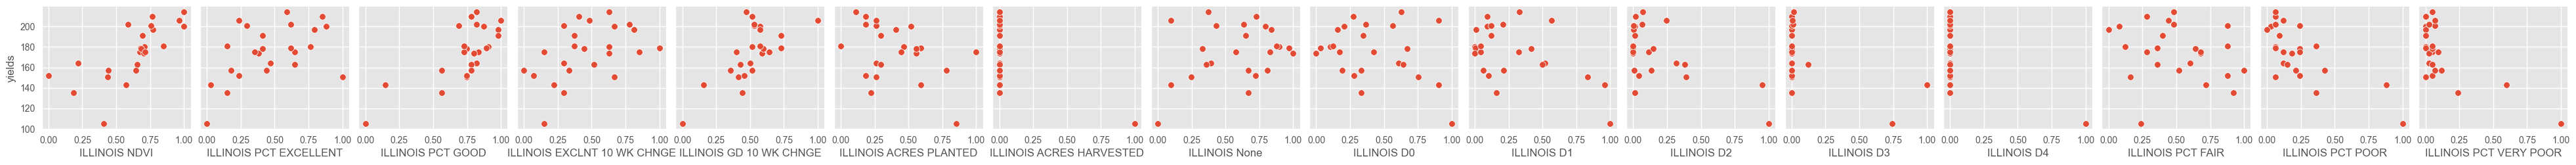

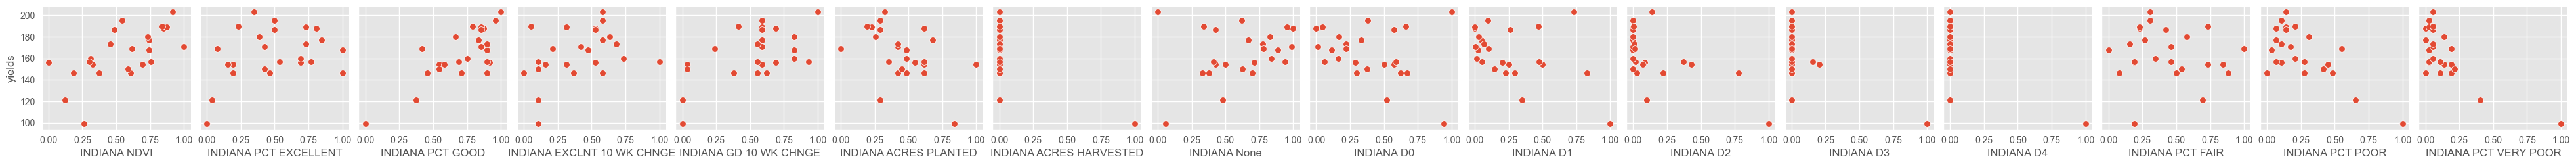

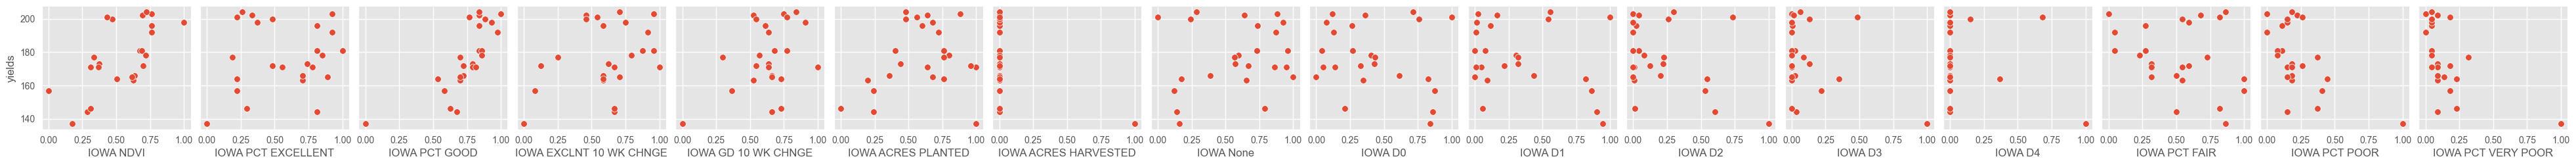

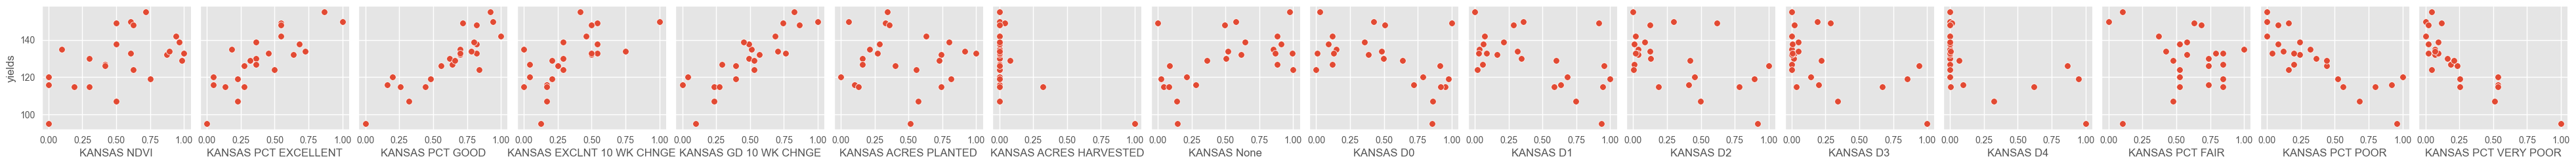

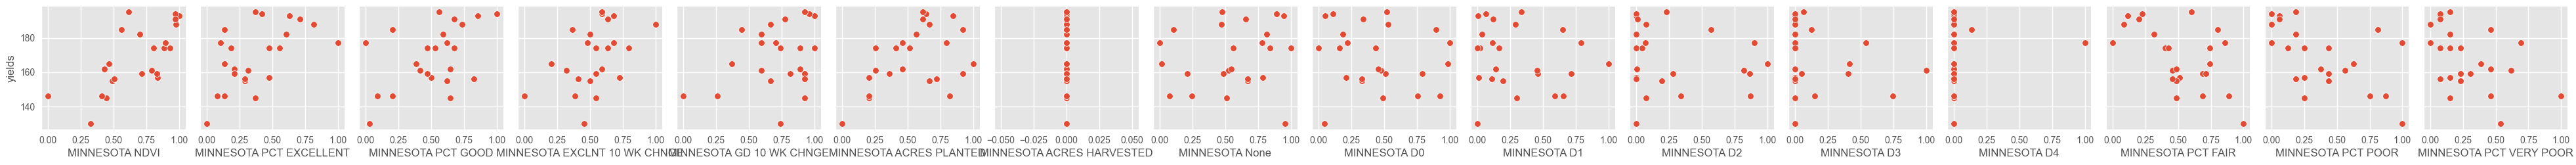

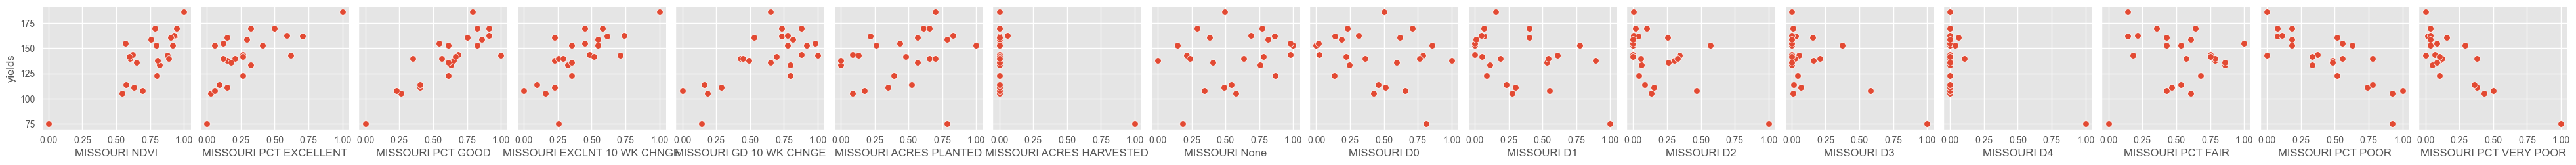

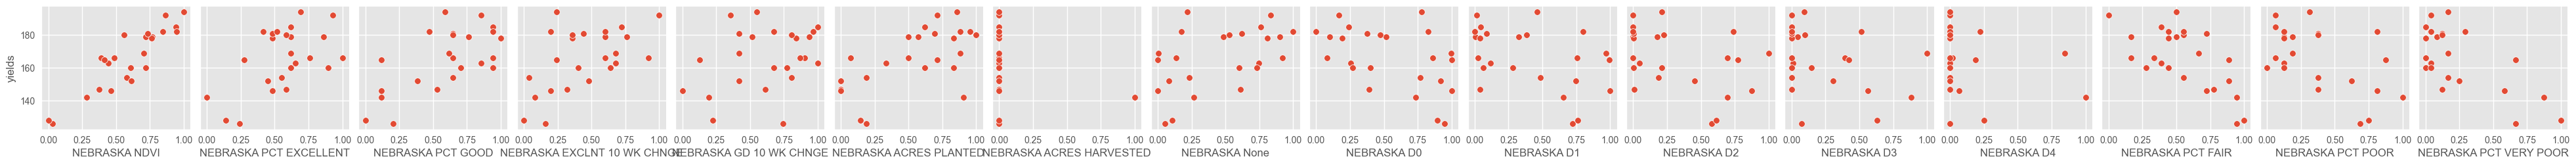

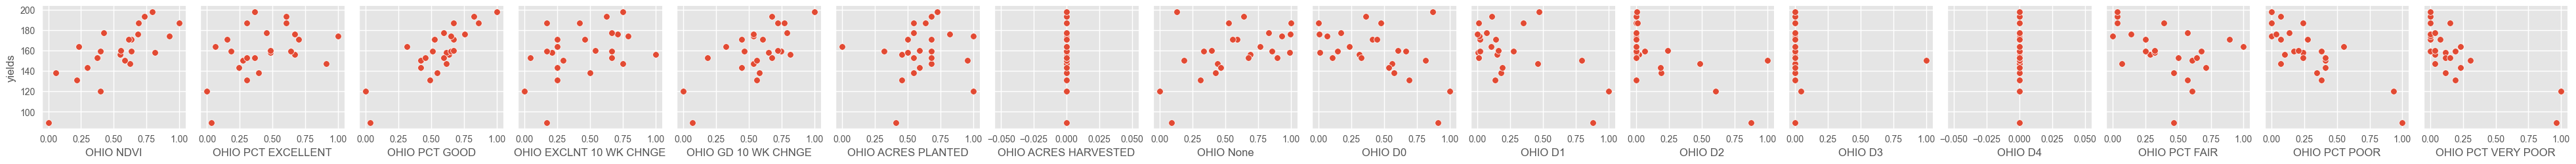

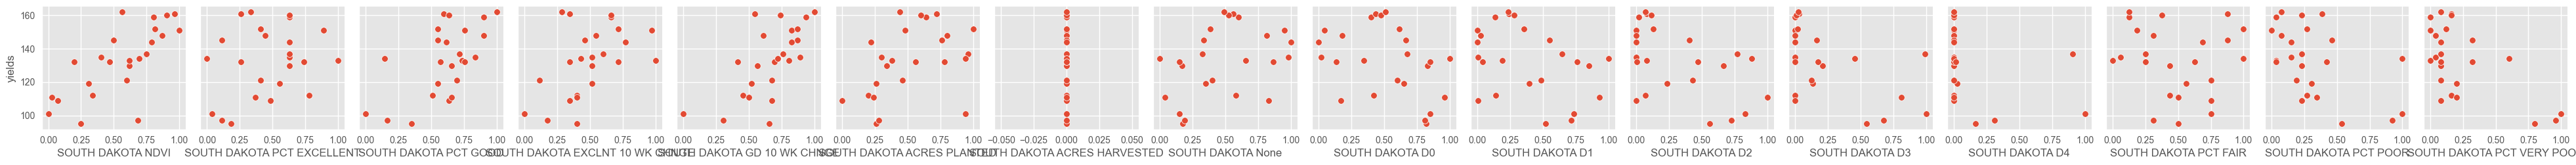

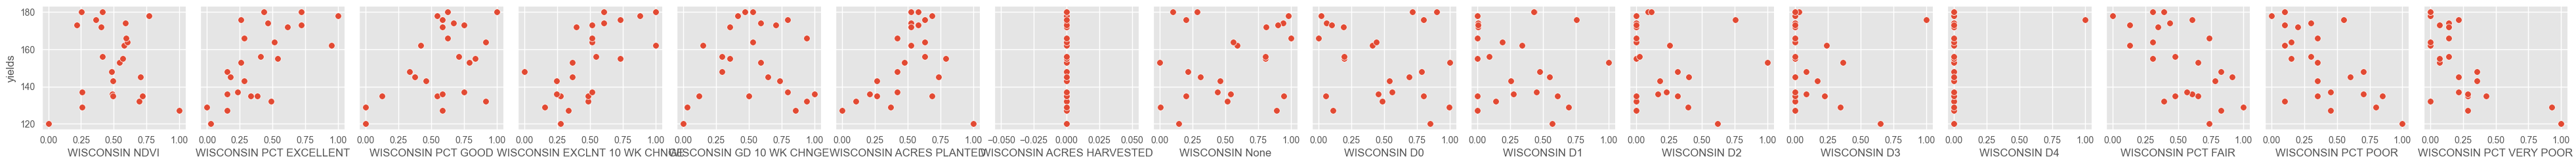

In [246]:
for state in y.columns:
    state_data = x.filter(regex=state)
    temp = pd.DataFrame(y[state], columns=[state])
    temp.reset_index(drop=True, inplace=True)
    g = sns.pairplot(state_data.assign(yields=temp[state]), y_vars=['yields'][:], x_vars=state_data.columns)
    sns.despine();

C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_35864\1467222656.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_35864\1467222656.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_35864\1467222656.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
C:\Users\Oliver Li\AppData\Local\Temp\ipykernel_35864\1467222656.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])


,SOUTH DAKOTA NDVI,OHIO NDVI,NEBRASKA NDVI,MISSOURI NDVI,MINNESOTA NDVI,IOWA NDVI,INDIANA NDVI,ILLINOIS NDVI,ILLINOIS PCT EXCELLENT,KANSAS PCT EXCELLENT,...,ILLINOIS PCT VERY POOR,INDIANA PCT VERY POOR,IOWA PCT VERY POOR,KANSAS PCT VERY POOR,MINNESOTA PCT VERY POOR,MISSOURI PCT VERY POOR,NEBRASKA PCT VERY POOR,OHIO PCT VERY POOR,SOUTH DAKOTA PCT VERY POOR,WISCONSIN PCT VERY POOR
0,0.340499,0.621601,0.029884,0.879042,0.442379,0.285127,0.375975,0.438817,1.000000,0.363636,...,0.000000,0.000000,0.090909,0.162791,0.153846,0.000000,0.666667,0.038462,0.16,0.000000
1,0.074472,0.055121,0.376607,0.818707,0.324482,0.308956,0.000000,0.000000,0.235294,0.363636,...,0.047619,0.027027,0.227273,0.186047,0.538462,0.051724,0.125000,0.115385,0.08,0.285714
2,0.249520,0.000000,0.000000,0.545901,0.832714,0.626130,0.123245,0.185908,0.147059,0.045455,...,0.238095,0.405405,0.090909,0.534884,0.153846,0.431034,1.000000,0.961538,0.80,0.285714
3,0.025720,0.548603,0.461761,0.693129,0.000000,0.000000,0.185647,0.218308,0.470588,0.045455,...,0.023810,0.108108,0.181818,0.534884,0.461538,0.500000,0.583333,0.038462,0.20,0.928571
4,0.616507,0.812663,0.388496,0.932448,0.828996,0.672966,0.742070,0.706197,0.764706,1.000000,...,0.000000,0.027027,0.045455,0.000000,0.307692,0.017241,0.000000,0.115385,0.08,0.285714


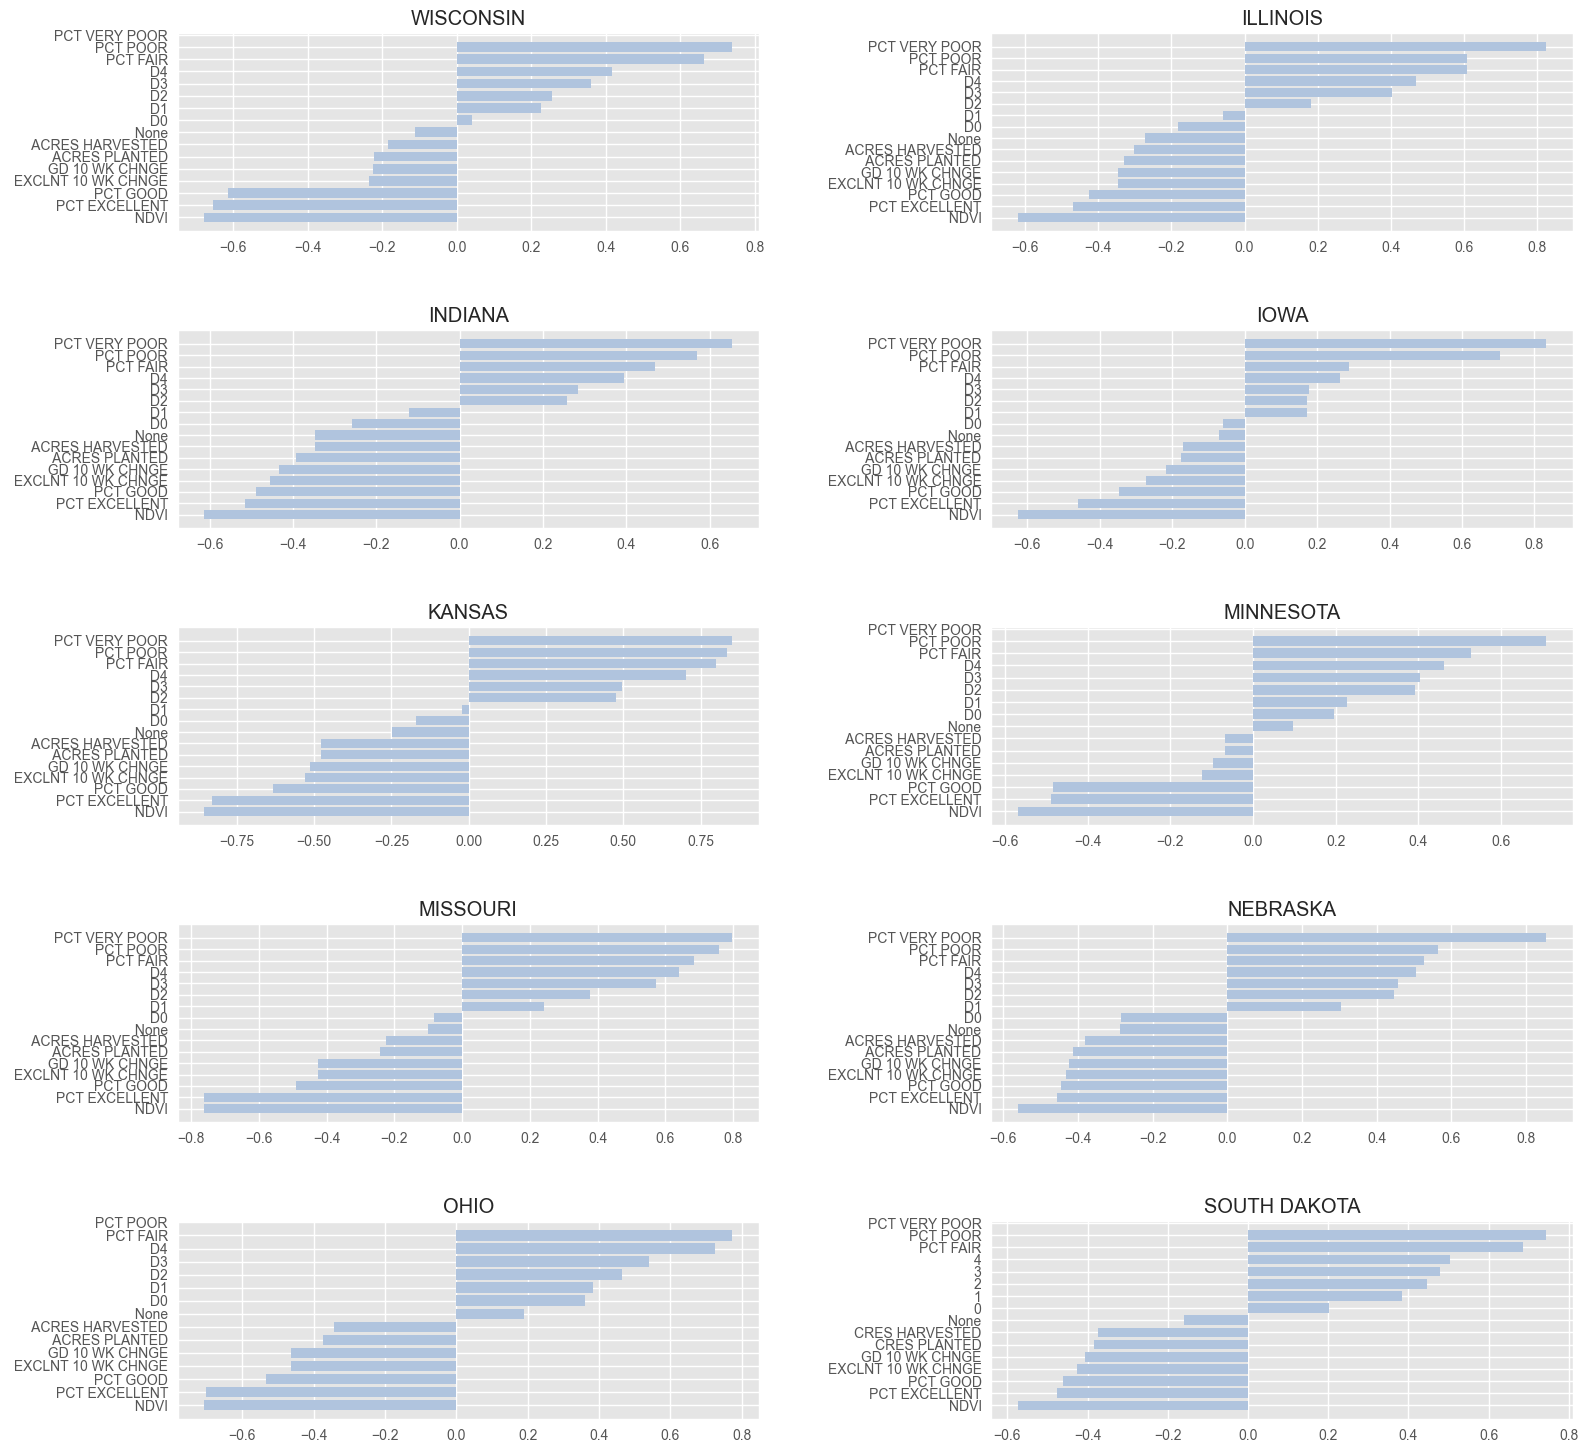

In [247]:
# Optional filtering based on Spearman correlation

def spearman_correlations(filter=True):
    fig, axs = plt.subplots(5, 2, figsize=(18, 18))

    for i, ax in enumerate(fig.axes):
        state = y.columns[i-1]
        corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
        if filter:
            temp = abs(corr)
            x.drop(columns=temp.nsmallest(math.floor(len(corr.index) / 2)).index, inplace=True)
        ax.barh(y=corr.index.str.lstrip(state), width=corr.sort_values(), color='lightsteelblue')
        ax.set_title(state);
    
    plt.subplots_adjust(hspace=0.5, wspace=0.4)

spearman_correlations(filter=True)
x.head()

,SOUTH DAKOTA NDVI,OHIO NDVI,NEBRASKA NDVI,MISSOURI NDVI,MINNESOTA NDVI,IOWA NDVI,INDIANA NDVI,ILLINOIS NDVI,ILLINOIS PCT EXCELLENT,KANSAS PCT EXCELLENT,...,SOUTH DAKOTA PCT POOR,WISCONSIN PCT POOR,INDIANA PCT VERY POOR,IOWA PCT VERY POOR,KANSAS PCT VERY POOR,MINNESOTA PCT VERY POOR,MISSOURI PCT VERY POOR,NEBRASKA PCT VERY POOR,OHIO PCT VERY POOR,WISCONSIN PCT VERY POOR
0,0.340499,0.621601,0.029884,0.879042,0.442379,0.285127,0.375975,0.438817,1.000000,0.363636,...,0.269231,0.10,0.000000,0.090909,0.162791,0.153846,0.000000,0.666667,0.038462,0.000000
1,0.074472,0.055121,0.376607,0.818707,0.324482,0.308956,0.000000,0.000000,0.235294,0.363636,...,0.230769,0.45,0.027027,0.227273,0.186047,0.538462,0.051724,0.125000,0.115385,0.285714
2,0.249520,0.000000,0.000000,0.545901,0.832714,0.626130,0.123245,0.185908,0.147059,0.045455,...,0.538462,0.35,0.405405,0.090909,0.534884,0.153846,0.431034,1.000000,0.961538,0.285714
3,0.025720,0.548603,0.461761,0.693129,0.000000,0.000000,0.185647,0.218308,0.470588,0.045455,...,0.346154,0.80,0.108108,0.181818,0.534884,0.461538,0.500000,0.583333,0.038462,0.928571
4,0.616507,0.812663,0.388496,0.932448,0.828996,0.672966,0.742070,0.706197,0.764706,1.000000,...,0.230769,0.70,0.027027,0.045455,0.000000,0.307692,0.017241,0.000000,0.115385,0.285714


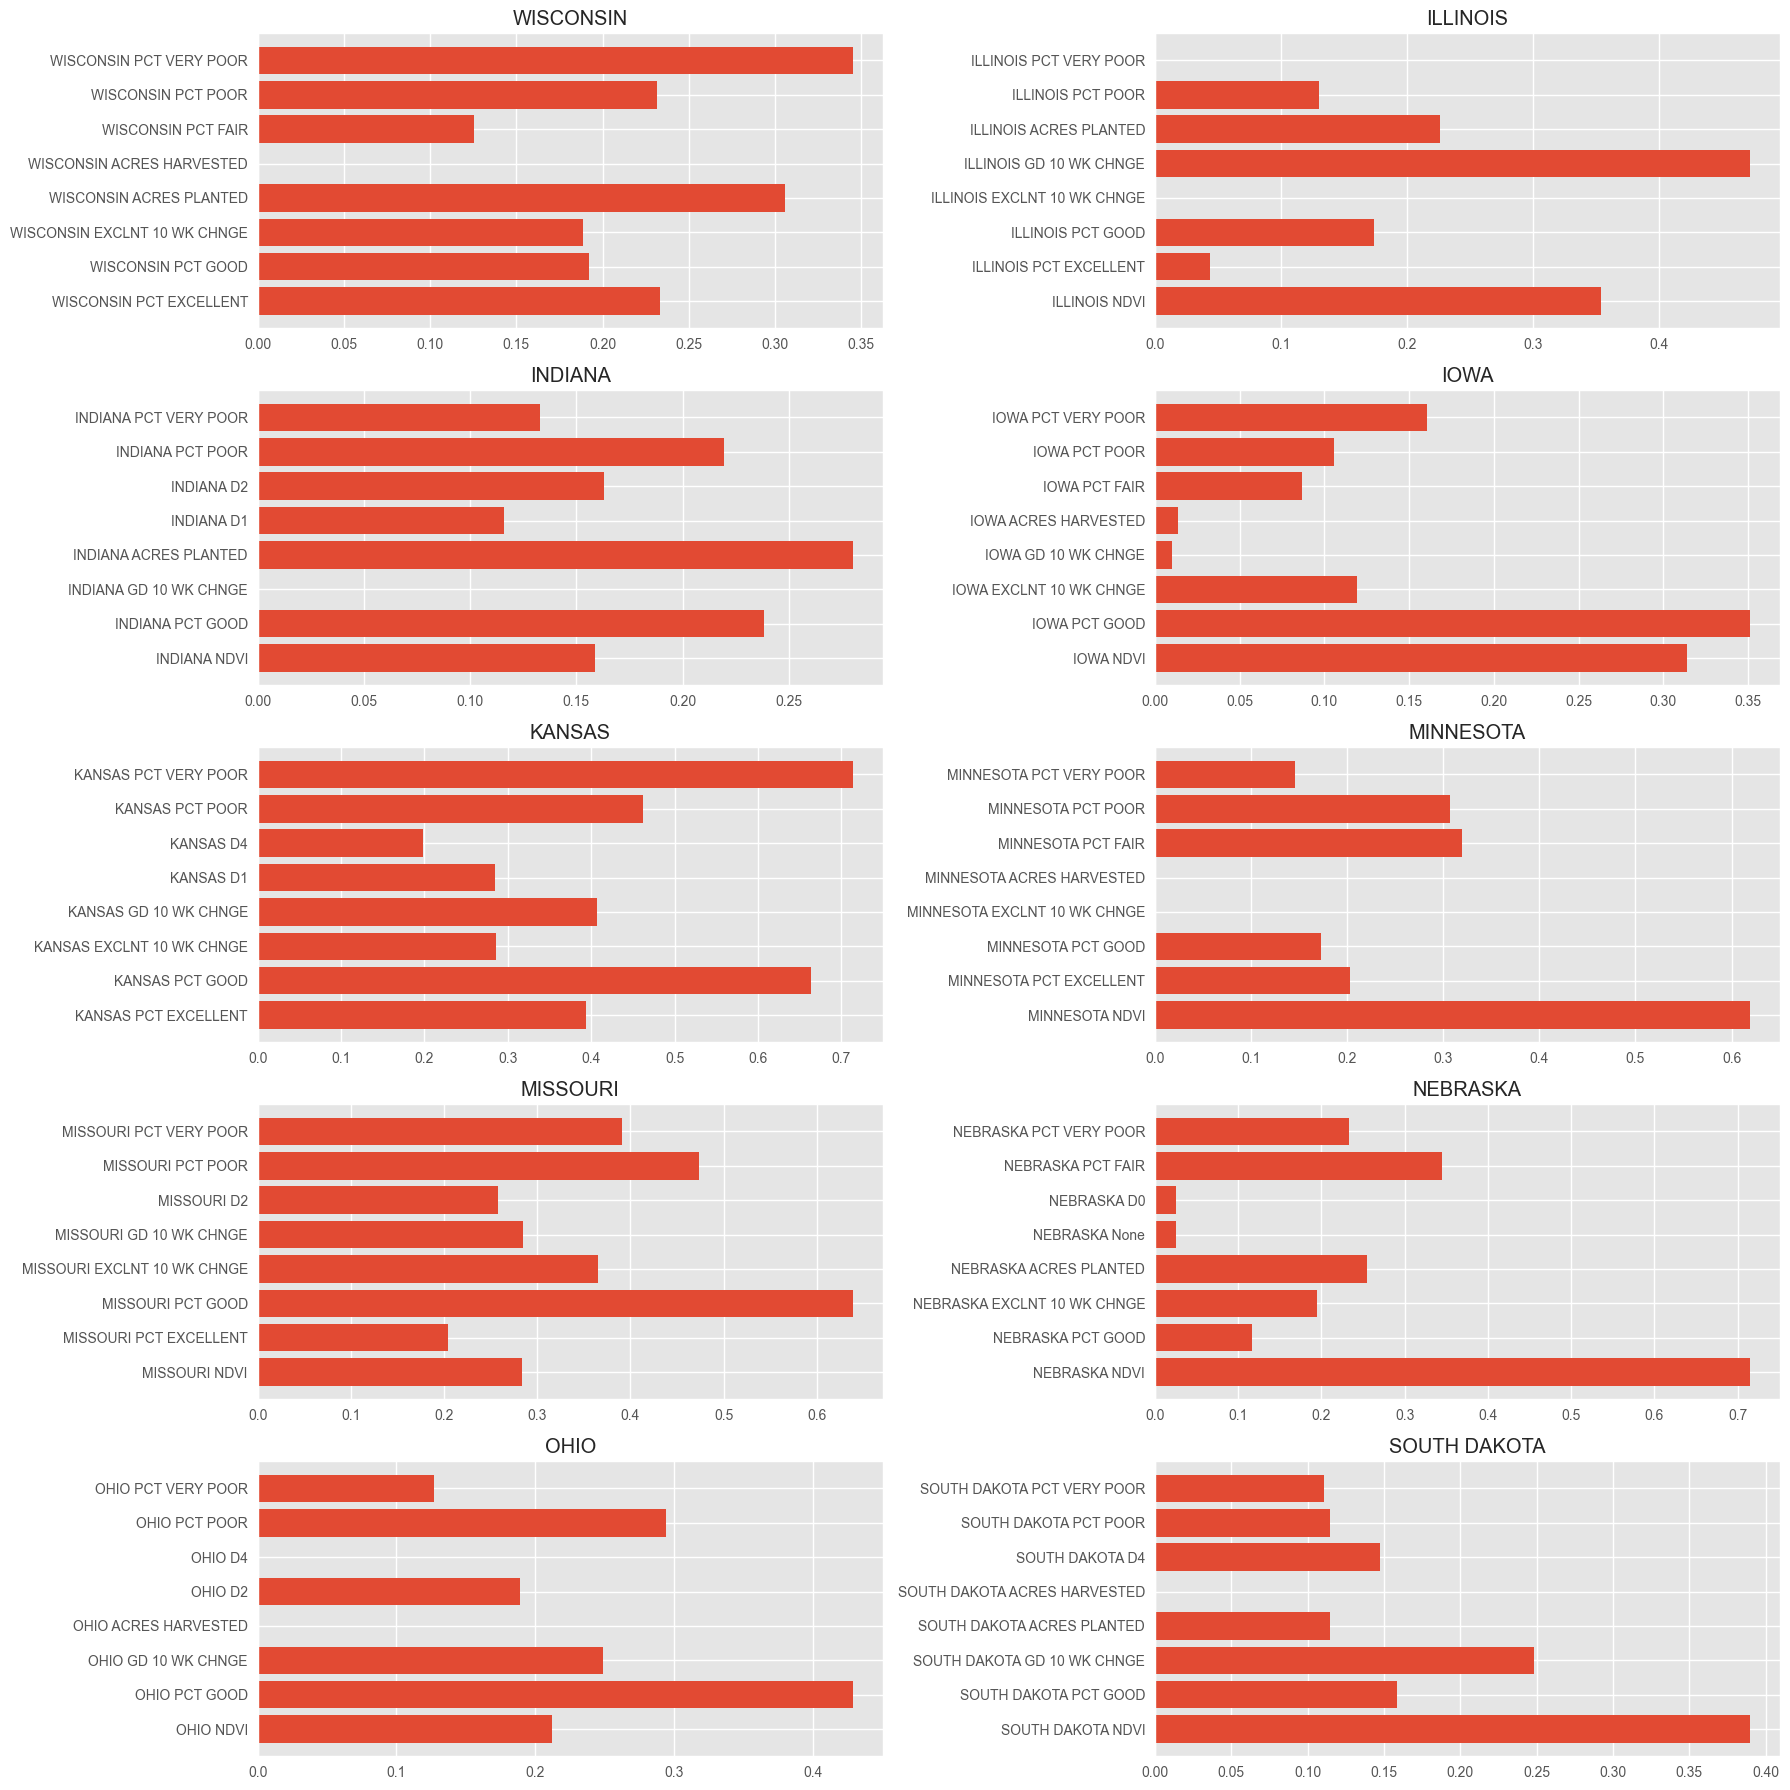

In [248]:
# Optional filtering based on mutual information
def mutual_information(filter=True):
    fig, axs = plt.subplots(5, 2, figsize=(18, 18))

    for i, ax in enumerate(fig.axes):
        state = y.columns[i-1]
        state_data = x.filter(regex=state)
        mi = mutual_info_regression(X=state_data,
                                    y=y[state],
                                    random_state=42
                                    )
        mutual_info = pd.DataFrame(mi, index=state_data.columns, columns=[state])
        if filter:
            x.drop(columns=mutual_info[state].nsmallest(math.floor(len(mutual_info.index) / 4)).index, inplace=True)
        ax.barh(state_data.columns, mutual_info[state])
        ax.set_title(state)
    plt.tight_layout()

mutual_information(filter=True)
x.head()

In [249]:

# Returns feature coefficients of regression model
def feature_importance(model, df, ax, num_features, plot=False, print_results=False):
        importance = model.coef_
        keys = list(df.keys())
        abs_weights = {}
        weights = {}
        for i,v in enumerate(importance):
            if print_results:
                print("Feature: %s, Score: %.5f" % (keys[i],v))
            abs_weights[keys[i]] = abs(v)
            weights[keys[i]] = v
        if plot:
            ax.bar([x for x in range(len(importance))], height=importance, color='b')
            tickvals = range(0, len(importance))
            cols = df.columns
            ax.set_xticks(ticks=tickvals, labels=cols, rotation=45, fontsize='xx-small', fontstretch='extra-condensed')
        
        largest_features = heapq.nlargest(num_features, abs_weights, key=abs_weights.get)

        avg_abs_weight = sum([abs_weights.get(key) for key in largest_features]) / len(largest_features)
        return largest_features, weights, avg_abs_weight

In [250]:

# Returns optimized model based on RandomSearchCV and specified parameters.

def get_best_model(X, y, kwargs=None, lasso=True, print_results=False):
    xgb_params = {
    "learning_rate": np.arange(0.01, 0.2, 0.01),
    "min_child_weight": np.arange(1, 5, 1),
    "n_estimators": range(800, 1200),
    "max_depth": range(1, 5),
    "colsample_bytree": np.arange(0.1, 1, 0.1),
    "subsample": np.arange(0.1, 1, 0.1)
    }

    lasso_params = {
        "alpha": np.arange(0.05, 2, 0.05)
    }

    if not lasso:
        optimized_model = RandomizedSearchCV(param_distributions=xgb_params, estimator=xgb.XGBRegressor(), scoring='r2', verbose=1, random_state=42, cv=2)
        optimized_model.fit(X, y)
        if print_results:
            print("Best Parameters:", optimized_model.best_params_)
    else: 
        optimized_model = RandomizedSearchCV(param_distributions=lasso_params, estimator=Lasso(random_state=42), scoring='r2', verbose=1, random_state=42)
        optimized_model.fit(X, y)
        if print_results:
            print("Best Parameters:", optimized_model.best_params_)
    return optimized_model

In [251]:
# Fitting models, analyzing and plotting data

def reg_plot(x, y, title, ax=None):
    X_train = x.iloc[0:16]
    X_test = x.iloc[16:20]
    X_cv = x.iloc[20:]
    y_train = y.iloc[0:16]
    y_test = y.iloc[16:20]
    y_cv = y.iloc[20:]


    # For most crops, a lower alpha (<= 0.7) is best. Higher alphas run the risk of reducing all coefficients to 0
    model = get_best_model(X_train, y_train).best_estimator_
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    weighted_features, weights, avg_abs_weight = feature_importance(model, X_train, ax, math.ceil(X_train.shape[1]))

    residuals = y_train - y_train_pred
    residuals = pd.DataFrame(residuals, index=y_train.index)

    monotone_csts = np.zeros(len(weighted_features))
    monotone_csts = np.array(monotone_csts, dtype=int)
    for i in range(len(weighted_features)):

        if weights[weighted_features[i]] < 0 and abs(weights[weighted_features[i]]) > avg_abs_weight:
            monotone_csts[i] = -1
        elif weights[weighted_features[i]] > 0 and weights[weighted_features[i]] > avg_abs_weight:
            monotone_csts[i] = 1

    kwargs = {
        "monotone_constraints": f"{tuple(monotone_csts)}"
    }

    resid_model = xgb.XGBRegressor(
                                **kwargs)
    resid_model.fit(X_train, residuals)

    ax.scatter(y_train.index, y_train)
    ax.plot(y_train.index, y_train_pred)
    pred2 = resid_model.predict(X_test) + y_test_pred
    pred2 = pd.DataFrame(pred2, index=y_test.index)
    ax.scatter(y_test.index, y_test)
    ax.plot(y_test.index, pred2)
    
    resid_cv = y_test - y_test_pred
    resid_cv = pd.DataFrame(resid_cv, index=y_test.index)

    resid_cv_model = xgb.XGBRegressor(
                                    **kwargs)
    resid_cv_model.fit(X_test, resid_cv)
    resid_cv_pred = resid_cv_model.predict(X_cv)
    pred3 = model.predict(X_cv)

    pred3 = resid_cv_pred + pred3

    pred3 = pd.DataFrame(pred3, index=y_cv.index)
    ax.scatter(y_cv.index, y_cv)
    ax.plot(y_cv.index, pred3)

    
    ax.set_title(title)

    s = mean_absolute_error(y_cv, pred3)
    at = AnchoredText(
        f"CV MAE: {s:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    return ax 

In [252]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

In [253]:

def cross_val_curves(x, y, ax):
    X_train = x.iloc[:16]
    y_train = y.iloc[:16]

    rmse_score = make_scorer(rmse)
    cv_rmse = {}
    alphas = list(np.arange(0.1, 3.0, 0.1))
    for alpha in alphas:
        pipe = Pipeline([('scaler', MinMaxScaler()),
                        ('lasso', Lasso(alpha=alpha))])
        cv_rmse[alpha] = cross_val_score(pipe,
                                        X=X_train,
                                        y=y_train,
                                        scoring=rmse_score,
                                        cv=5)


    cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
    best_alpha, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
    cv_rmse = cv_rmse.stack().reset_index()
    cv_rmse.columns=['alpha', 'iter', 'RMSE']
    ax = sns.lineplot(x='alpha', y='RMSE', data=cv_rmse, ax=ax)
    ax.set_title(f'Cross-Validation Results Lasso | Best alpha: {best_alpha} | Best RMSE: {best_rmse:.2f}');

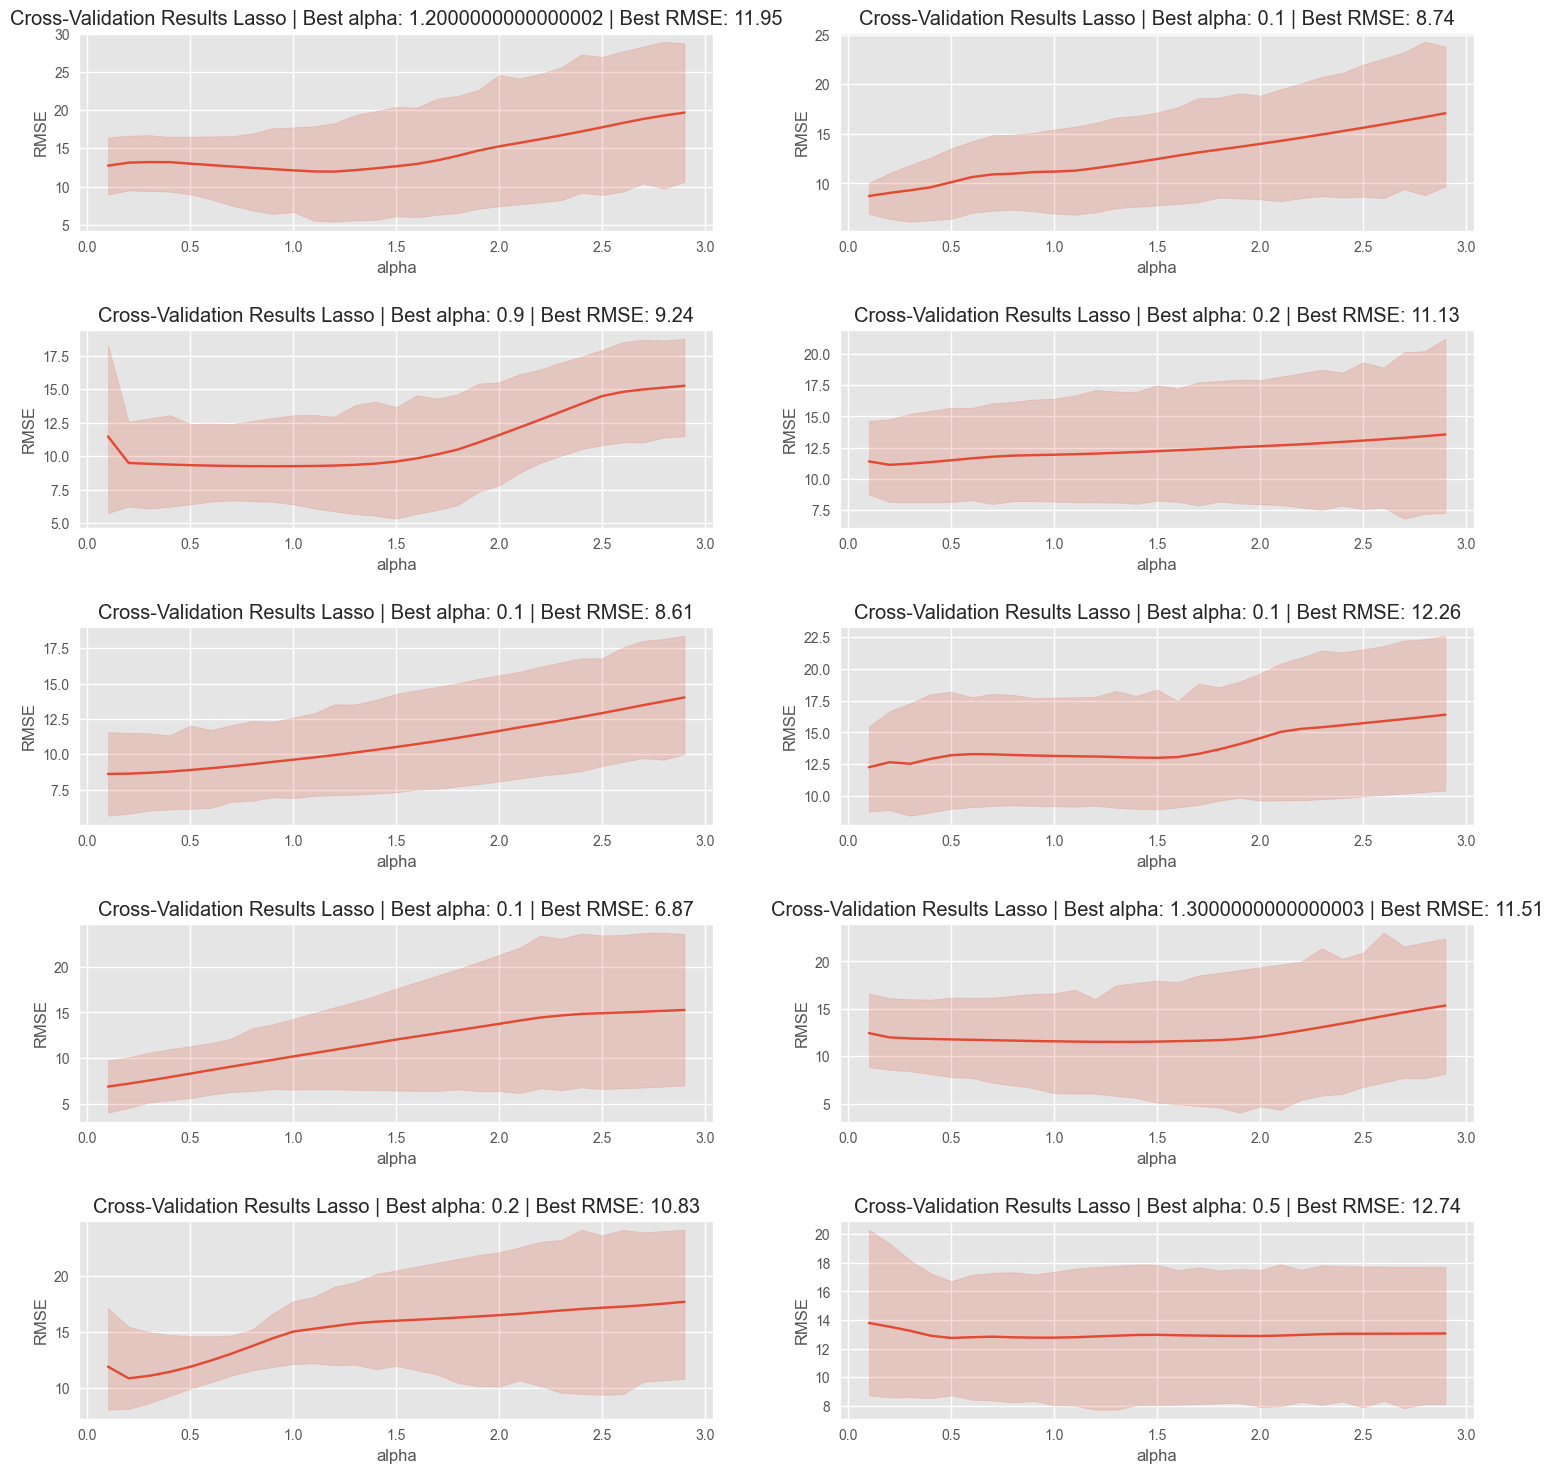

In [254]:
fig, axs = plt.subplots(5, 2, figsize=(18, 18))
for i, ax in enumerate(fig.axes):
    state = y.columns[i]
    cross_val_curves(x.filter(regex=state), y[state], ax=ax)
plt.subplots_adjust(hspace=0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


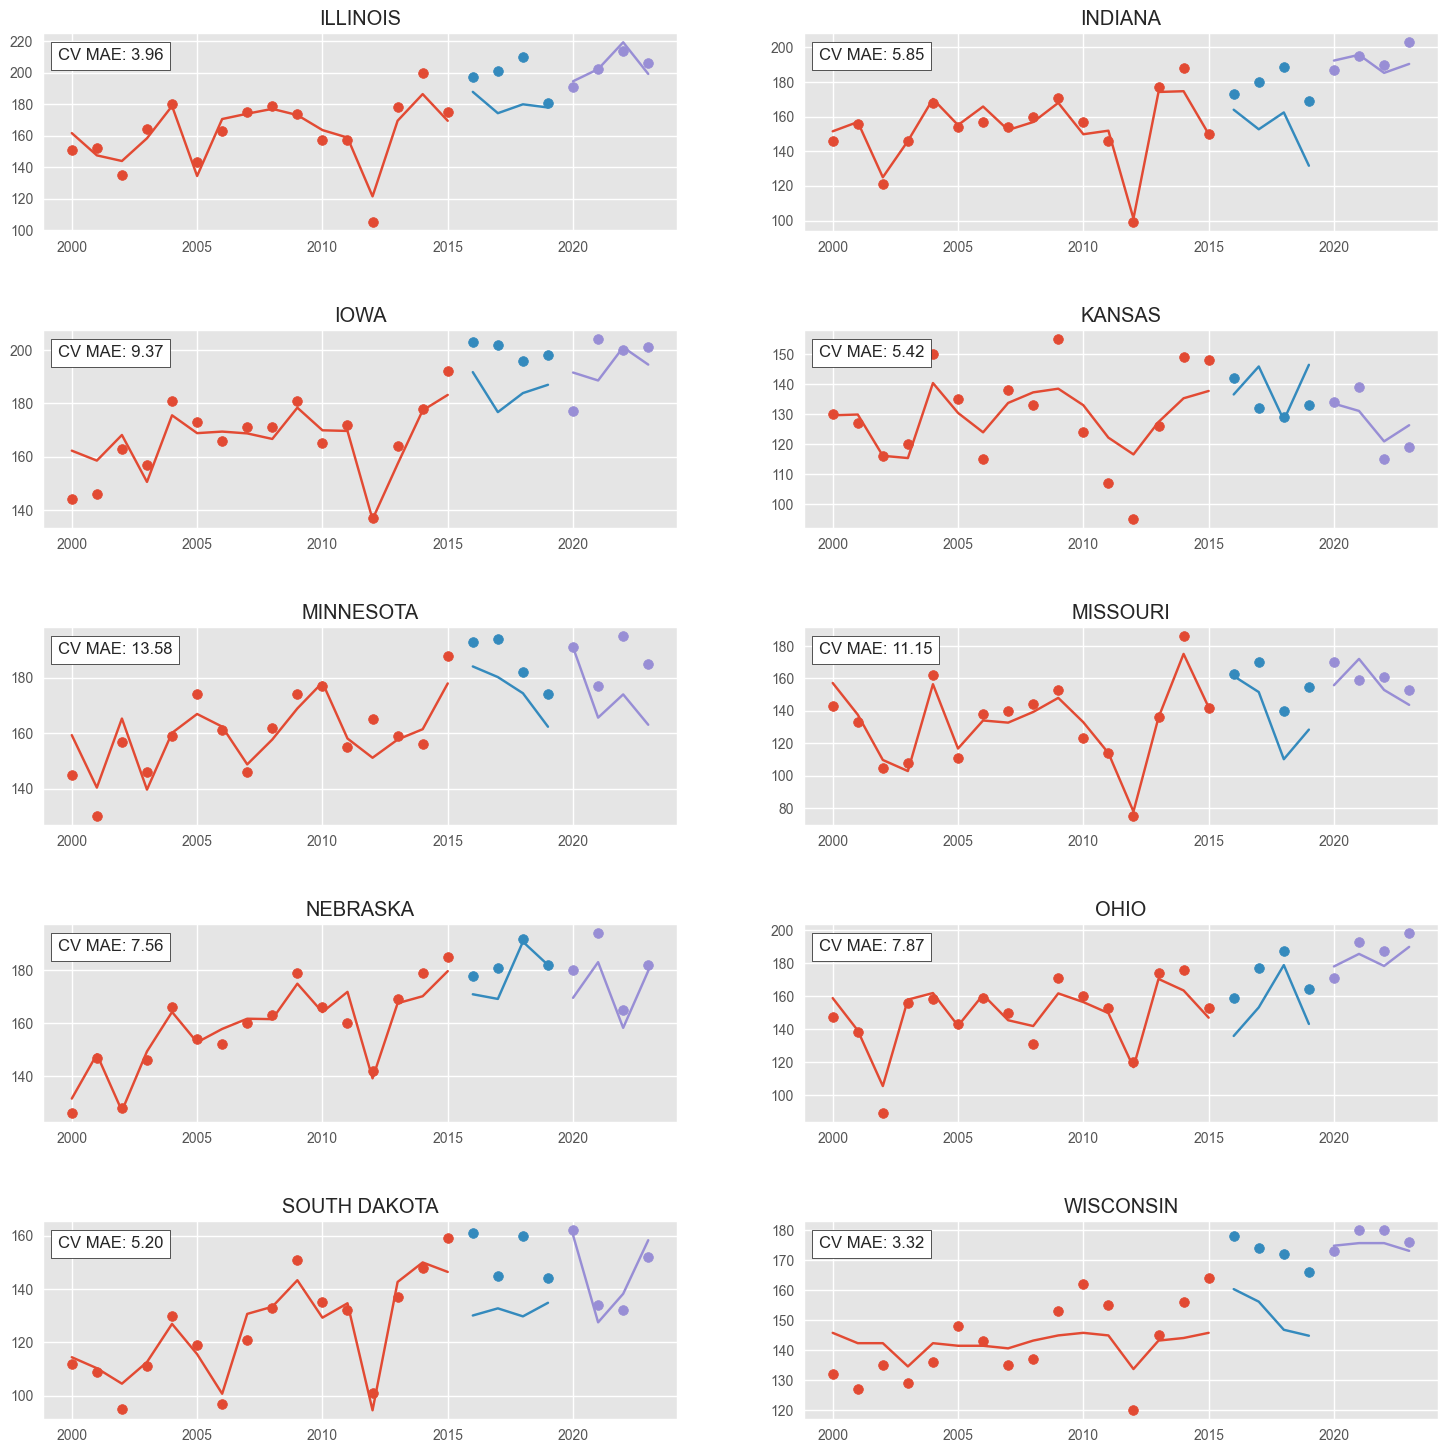

In [255]:

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

for i, ax in enumerate(fig.axes):
    col_name = y.columns[i]
    state_data = x.filter(regex=col_name)
    input = state_data
    if "D1" in x.columns:
        drought_data = x.loc[:, ["D1", "D2", "D3", "D4"]]
        input = pd.concat([input, drought_data], axis=1, ignore_index=False)

    reg_plot(input, y.iloc[:, i], col_name, ax)

plt.subplots_adjust(hspace=0.5)
plt.show()